
#dora#


dora is a light-weight python library with a RESTful API that provides a simple interface to powerful active sampling models.

The two core calls of any dora sampler are the `pick()` and an `update()` functions.

`pick()` asks the sampler to choose a set of parameters or a location in feature space where an observation would be the most beneficial based on a user-provided metric.

`update()` updates the sampler with the information obtained by an observation, allowing the sampler to propogate the knowledge through to all future predictions and `pick()` calls.


## Simple example ##
This demo aims to highlight dora's features and use cases.

Initially we will examine using the active sampling module as a python library to find the maximum of a non-convex function that is considered expensive to evaluate.

First, lets begin by importing the relevant packages

In [1]:
import numpy as np
import logging
from scipy.stats import norm
import dora.active_sampling as sampling
import time
from dora.active_sampling import pltutils
import matplotlib.pyplot as pl
import matplotlib as mpl
%matplotlib inline


### Problem Setup ###

Next we define a 1-D function, `ground_truth()`, that is unknown to the user but that can be evaluated when given an input variable, `x`. 

In [2]:
def ground_truth(X):
    return np.sin(X-5) + np.sin(X/2-2) + 0.4*np.sin(X/5-2) + 0.4*np.sin(X-3) + 0.2*np.sin(X/0.3-3)

Next we need to set the bounds for the problem. In this example, the space is one dimensional. So the upper and lower bounds will both be lists with one element in each.

In [3]:
# Set up a problem bounds
lower = [0]
upper = [30]

For illustrative purposes, lets plot the latent function, `ground_truth()`, over a range of x.

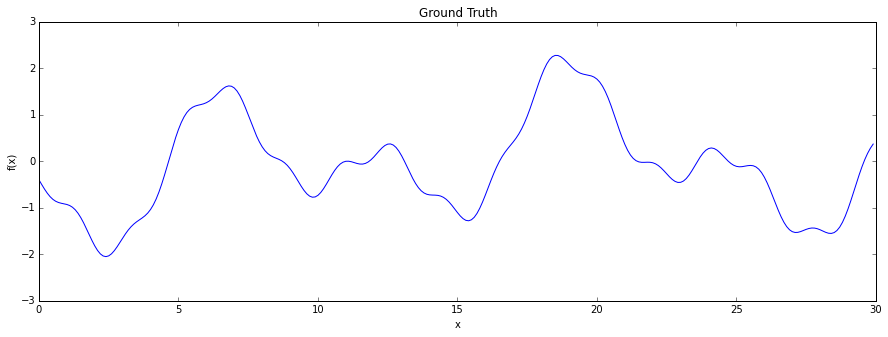

In [4]:
x = np.arange(0,30,0.1)
fx = ground_truth(x)
pl.figure(figsize=(15,5))
pl.plot(x,fx); 
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth')
pl.show()

### Initialise the Sampler ###


If we provide the sampler with no initial data, it must first randomly sample the underlying function to build an approximate model of its behaviour before it can begin suggesting new points to observe. Consequently we specify the number of random samples it should acquire before training a model.


In [5]:
n_train = 8

The sampler uses an acquisition function to determine what the next most beneficial datapoint to obtain would be. The quantification of the benefit varies from application to application. As a result, the user is free to provide their own acquisition function or choose an existing one from the dora library.

In this instances, `pred_upper_bound`, an aquisition function which is the predicted upper bound of the sampler's model will be used.

In [6]:
acq_name = 'pred_upper_bound'

We also set an explore_priority scalar. The larger this value, the more the sampler will seek to explore areas of the parameter space with sparse observations rather than attempting to refine an area where the model believes will maximise it's objective function.

In [7]:
explore_priority = 1.

When initialising the sampler, we specify the class of the model it will base its predictions on. In this case, it's the Gaussian process. Seeding the model is unnecessary unless the user desires a consistent set of initial picks prior to training.

In [8]:
sampler = sampling.GaussianProcess(lower, upper, acq_name=acq_name,
                                           n_train=n_train, seed=11)
    

### Active sampling strategy

In [42]:
xq, uid = sampler.pick()


       x: (0.5291627373880746, 1.2511409948543377, -6.0)
     fun: 3.4004613091613556
     jac: array([ -1.37667655e-06,   8.88178420e-08,   4.00268751e-01])
    nfev: 75
 success: True
  status: 0
     nit: 12
 message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [43]:
yq_true = ground_truth(xq)

In [44]:

# Update the sampler about the new observation
sampler.update(uid, yq_true)



8

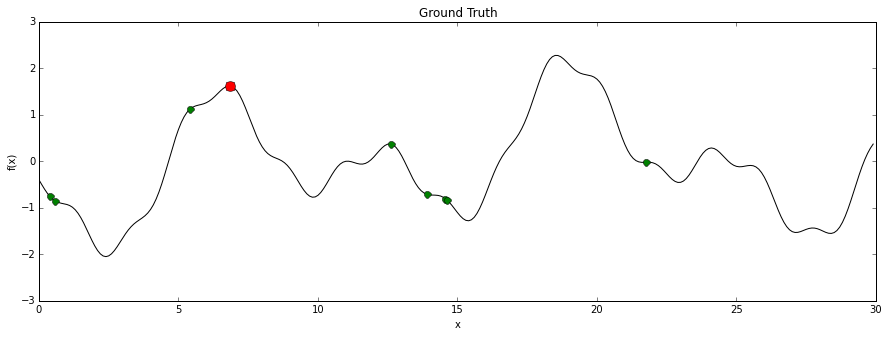

In [45]:
pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=7)
pl.plot(sampler.X[-1], sampler.y[-1],'ro', markersize=10)
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth')
pl.show()

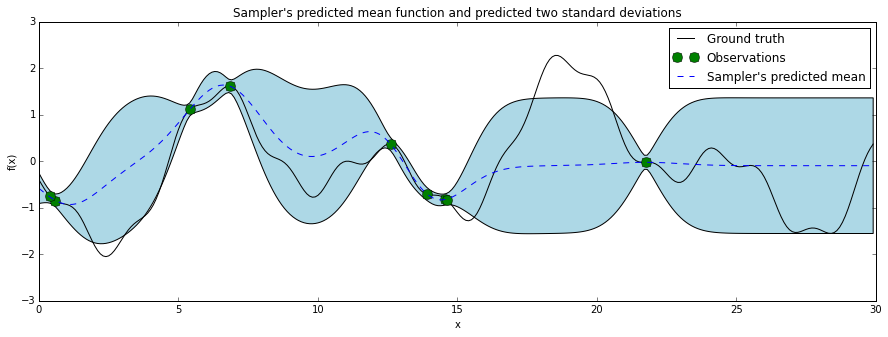

In [46]:
xquery = x[:,np.newaxis]
mf, vf = sampler.predict(xquery)
pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=10)
pl.plot(xquery, mf,'b--')
y1 = mf - np.sqrt(vf)*2
y2 = mf + np.sqrt(vf)*2
pl.fill_between(xquery[:,0], y1[:,0], y2[:,0], where=(y2 >= y1)[:,0], facecolor='lightblue')
#pl.plot(xquery,mf + np.sqrt(vf)*2, 'g--')
#pl.plot(xquery,mf - np.sqrt(vf)*2, 'g--')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.legend(('Ground truth', 'Observations', "Sampler's predicted mean",'Predicted 2 standard deviation','wtf'))
pl.title("Sampler's predicted mean function and predicted two standard deviations")
pl.show()

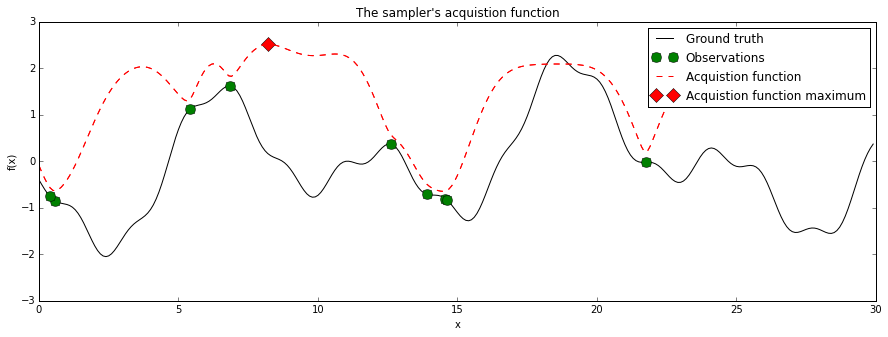

In [47]:
acq_value, acq_max_ind = sampler.eval_acq(x)

pl.figure(figsize=(15,5))
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'go', markersize=10)
pl.plot(x, acq_value,'r--')
pl.plot(x[acq_max_ind], acq_value[acq_max_ind],'rD', markersize=10)
pl.plot(x, acq_value,'r--')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title("The sampler's acquistion function")
pl.legend(('Ground truth', 'Observations', 'Acquistion function', 'Acquistion function maximum') )
pl.show()

In [48]:
acq_max_ind

82

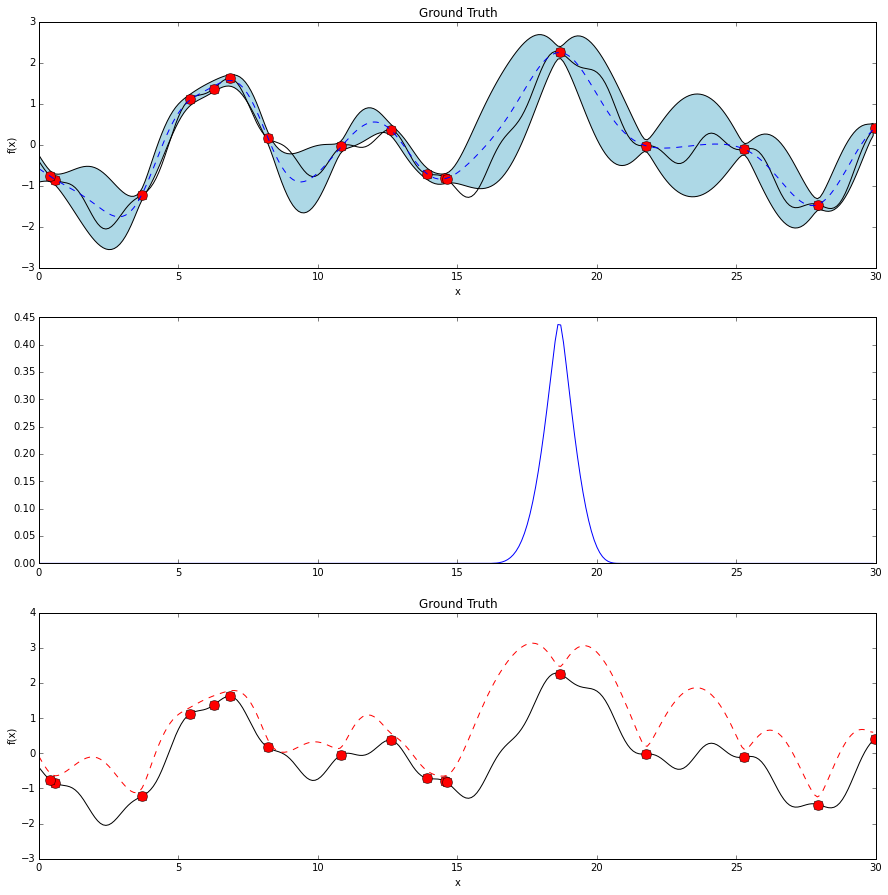

In [57]:
xq, uid = sampler.pick()

yq_true = ground_truth(xq)

# Update the sampler about the new observation
sampler.update(uid, yq_true)

xquery = x[:,np.newaxis]
mf, vf = sampler.predict(xquery)
pl.figure(figsize=(15,15))
pl.subplot(3,1,1)
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'ro', markersize=10)
pl.plot(xquery, mf,'b--')
y1 = mf - np.sqrt(vf)*2
y2 = mf + np.sqrt(vf)*2
pl.fill_between(xquery[:,0], y1[:,0], y2[:,0], where=(y2 >= y1)[:,0], facecolor='lightblue')
#pl.plot(xquery,mf + np.sqrt(vf)*2, 'g--')
#pl.plot(xquery,mf - np.sqrt(vf)*2, 'g--')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth')

maxObs = np.max(sampler.y)
mean_var_pairs = zip(mf,vf)
#[print(i) for i in mv]
#pl.figure(figsize=(7,7))
pl.subplot(3,1,2)
prob_great_maxy = np.asarray([1-norm.cdf(maxObs,mv[0],np.sqrt(mv[1])) for mv in mean_var_pairs])
pl.plot(x,prob_great_maxy)


acq_value, acq_max_ind = sampler.eval_acq(x)

#pl.figure(figsize=(7,7))
pl.subplot(3,1,3)
pl.plot(x,fx,'k'); 
pl.plot(sampler.X, sampler.y,'ro', markersize=10)
pl.plot(x, acq_value,'r--')
pl.xlabel('x')
pl.ylabel('f(x)')
pl.title('Ground Truth')



pl.show()



Okay, now lets start asking the sampler for locations to sample. The following loop requests a location in the parameter space to observe (xq). It then queries the simulation at that location and then updates the sampler with the acquired observation.

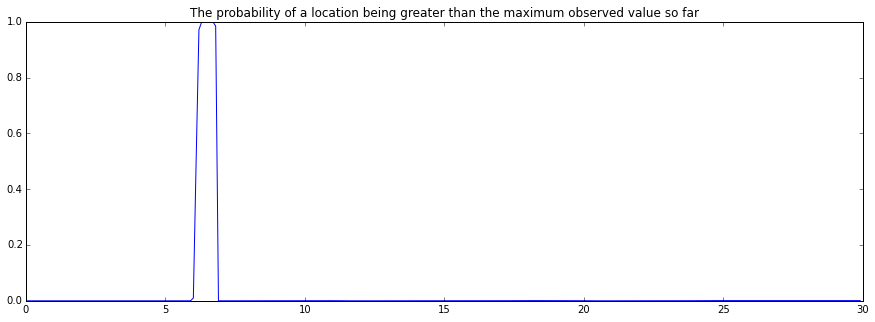

In [50]:
maxObs = np.max(sampler.y)
mean_var_pairs = zip(mf,vf)
#[print(i) for i in mv]
pl.figure(figsize=(15,5))
pl.title("The probability of a location being greater than the maximum observed value so far")
prob_great_maxy = np.asarray([1-norm.cdf(maxObs,mv[0],mv[1]) for mv in mean_var_pairs])
pl.plot(x,prob_great_maxy)

In [4]:
# Run the active sampling:
for i in range(10):

    xq, uid = sampler.pick()
    observation = simulate_measurement(xq)
    sampler.update(uid, observation)

This next cell of code plots the samples acquired to date as well as the Delaunay triangulation used to determine where to sample next based on variation within the triangles and their size. The background is coloured based on the model's predictions using the vertices of triangles (observations).

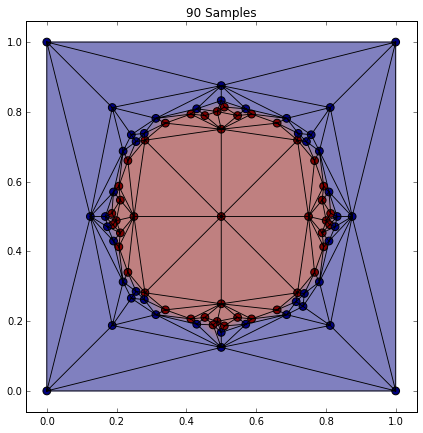

In [34]:
        
cols = pl.cm.jet(np.linspace(0, 1, 64))
custom = mpl.colors.ListedColormap(cols * 0.5 + 0.5)
y = sampler.y()
w = 4. / np.log(1 + len(y))
X = sampler.X()
if y.ndim == 2:
    y = y[:, 0]
    
pl.figure(figsize=(7,7))
pl.tripcolor(X[:, 0], X[:, 1], y, shading='gouraud',
             edgecolors='k', linewidth=w, cmap=custom)
pl.triplot(X[:, 0], X[:, 1], color='k', linewidth=w)
pl.scatter(X[:, 0], X[:, 1], c=y, s=60)
pl.axis('image')
pl.title('%d Samples' % len(y))
pl.show()


In [20]:
# Run the active sampling:
for i in range(10):

    xq, uid = sampler.pick()
    observation = simulate_measurement(xq)
    sampler.update(uid, observation)

In [ ]:
cols = pl.cm.jet(np.linspace(0, 1, 64))
custom = mpl.colors.ListedColormap(cols * 0.5 + 0.5)
y = sampler.y()
w = 4. / np.log(1 + len(y))
X = sampler.X()
if y.ndim == 2:
    y = y[:, 0]
    
pl.figure(figsize=(7,7))
pl.tripcolor(X[:, 0], X[:, 1], y, shading='gouraud',
             edgecolors='k', linewidth=w, cmap=custom)
pl.triplot(X[:, 0], X[:, 1], color='k', linewidth=w)
pl.scatter(X[:, 0], X[:, 1], c=y)
pl.axis('image')
pl.title('%d Samples' % len(y))
pl.show()